In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sacc
import yaml

In [2]:
path = "/home/jaimerz/Documents/UCL/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/txpipe/source_s16a_lens_dr1/all-fields/dndz/"
DS_s = sacc.Sacc.load_fits(path+"summary_statistics_fourier_all_SourcesS16A_LensesDR1_pz_mc_eab_HikageShearSC_DESC_GCandGGL_SC_kmax_0.15_1.471COVMAT.sacc")

In [3]:
DS_nzs = {}
for (name, tracer) in DS_s.tracers.items():
    DS_nzs[name] = [tracer.z, tracer.nz]

In [4]:
path = 'data/HSC/DESwl_final_HSC_cls_NzMarg_cov_p5.0_area2_diag4.0.fits'
CGG_s = sacc.Sacc.load_fits(path)

In [5]:
covs_carlos = np.load('data/HSC/DESwl_final_HSC_covNzMarg_p5.0_diag4.0.npz')
nzs_TQ = np.load('data/HSC/HSC_nzs_TQ.npz')

In [6]:
CGG_nzs = {}
for i, (name, tracer) in enumerate(CGG_s.tracers.items()):
    print(name)
    z = tracer.z[:100]
    nz = tracer.nz[:100]
    dndz = nz*np.mean(np.diff(z))
    norm = np.sum(dndz)
    dndz /= norm
    cov = covs_carlos['cov_nz'][100*i:100*(i+1)][:, 100*i:100*(i+1)][:100][:,:100]
    cov = cov/norm**2
    CGG_nzs[name] = [z, dndz, cov]

DESwl__0
DESwl__1
DESwl__2
DESwl__3
HSC__0
HSC__1
HSC__2
HSC__3


In [7]:
CGG_nzs['HSC__0'][2]

array([[ 3.43883652e-06, -3.66592561e-09, -9.84087038e-09, ...,
         2.42901702e-12, -4.35293067e-11, -2.29690789e-11],
       [-3.66592561e-09,  4.10682812e-06, -2.84627724e-08, ...,
         1.17499556e-11, -9.03536061e-11, -4.82058128e-11],
       [-9.84087038e-09, -2.84627724e-08,  5.84594663e-05, ...,
         1.19612012e-10, -6.00129462e-10, -3.11899029e-10],
       ...,
       [ 2.42901702e-12,  1.17499556e-11,  1.19612012e-10, ...,
         1.66029812e-07,  2.29071946e-09,  4.13805246e-10],
       [-4.35293067e-11, -9.03536061e-11, -6.00129462e-10, ...,
         2.29071946e-09,  7.91002593e-07,  6.96516935e-09],
       [-2.29690789e-11, -4.82058128e-11, -3.11899029e-10, ...,
         4.13805246e-10,  6.96516935e-09,  5.28884691e-07]])

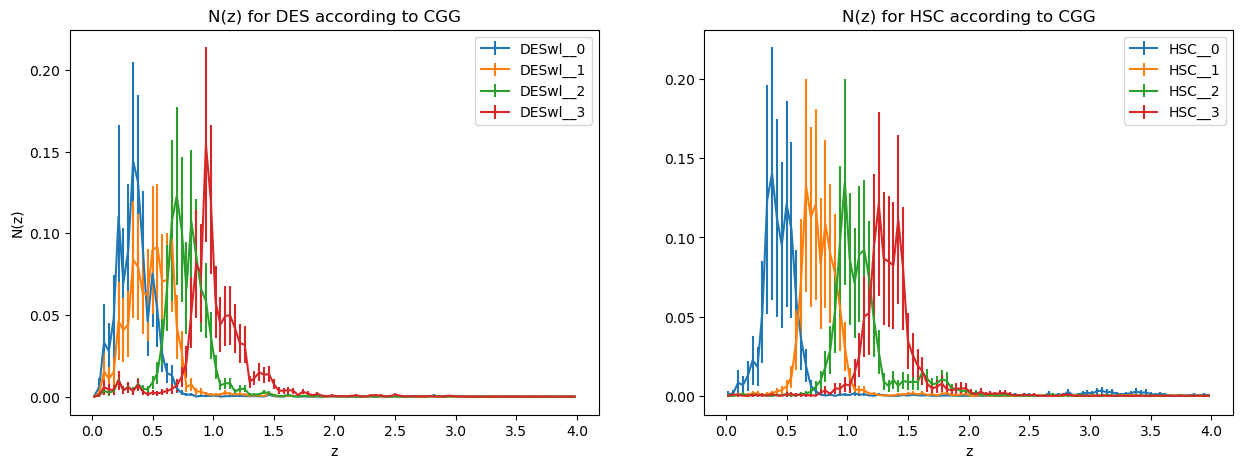

In [8]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
for (name, nz) in CGG_nzs.items():
    if 'DES' in name:
        axes[0].errorbar(nz[0], nz[1], yerr=np.sqrt(np.diag(nz[2])), label=name)
        axes[0].legend()
        axes[0].set_xlabel('z')
        axes[0].set_ylabel('N(z)')
        axes[0].set_title('N(z) for DES according to CGG')
    if 'HSC' in name:
        axes[1].errorbar(nz[0], nz[1], yerr=np.sqrt(np.diag(nz[2])), label=name)
        axes[1].legend()
        axes[1].set_xlabel('z')
        axes[1].set_title('N(z) for HSC according to CGG')
plt.show()

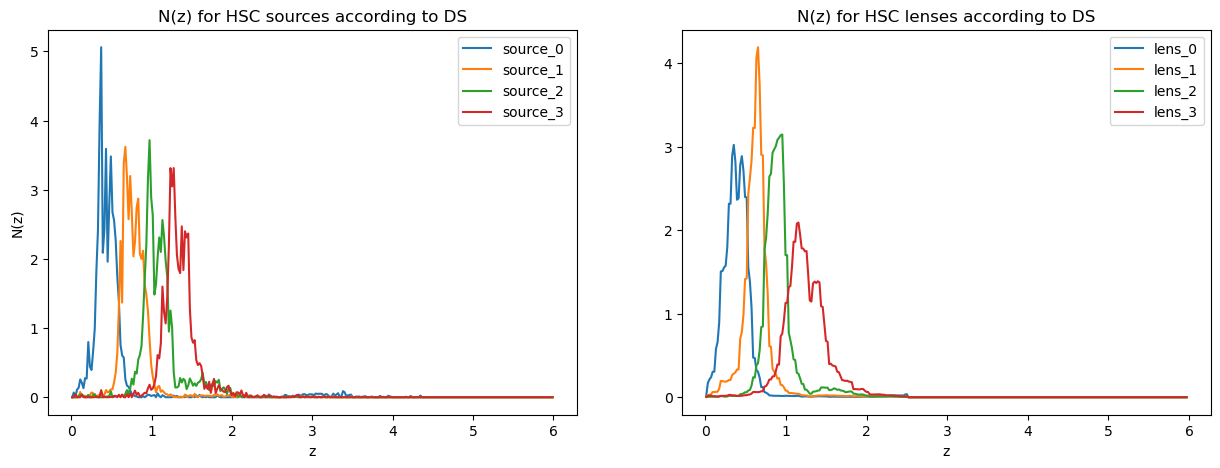

In [9]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
for (name, nz) in DS_nzs.items():
    if 'lens' in name:
        axes[1].plot(nz[0], nz[1], label=name)
        axes[1].legend()
        axes[1].set_xlabel('z')
        axes[1].set_title('N(z) for HSC lenses according to DS')

    else:
        axes[0].plot(nz[0], nz[1], label=name)
        axes[0].legend()
        axes[0].set_xlabel('z')
        axes[0].set_ylabel('N(z)')
        axes[0].set_title('N(z) for HSC sources according to DS')

plt.legend()
plt.show()

## Post-process Carlos

In [10]:
def make_sym(A):
    return np.maximum(A, A.transpose())

/tmp/ipykernel_8094/4160077093.py:12: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


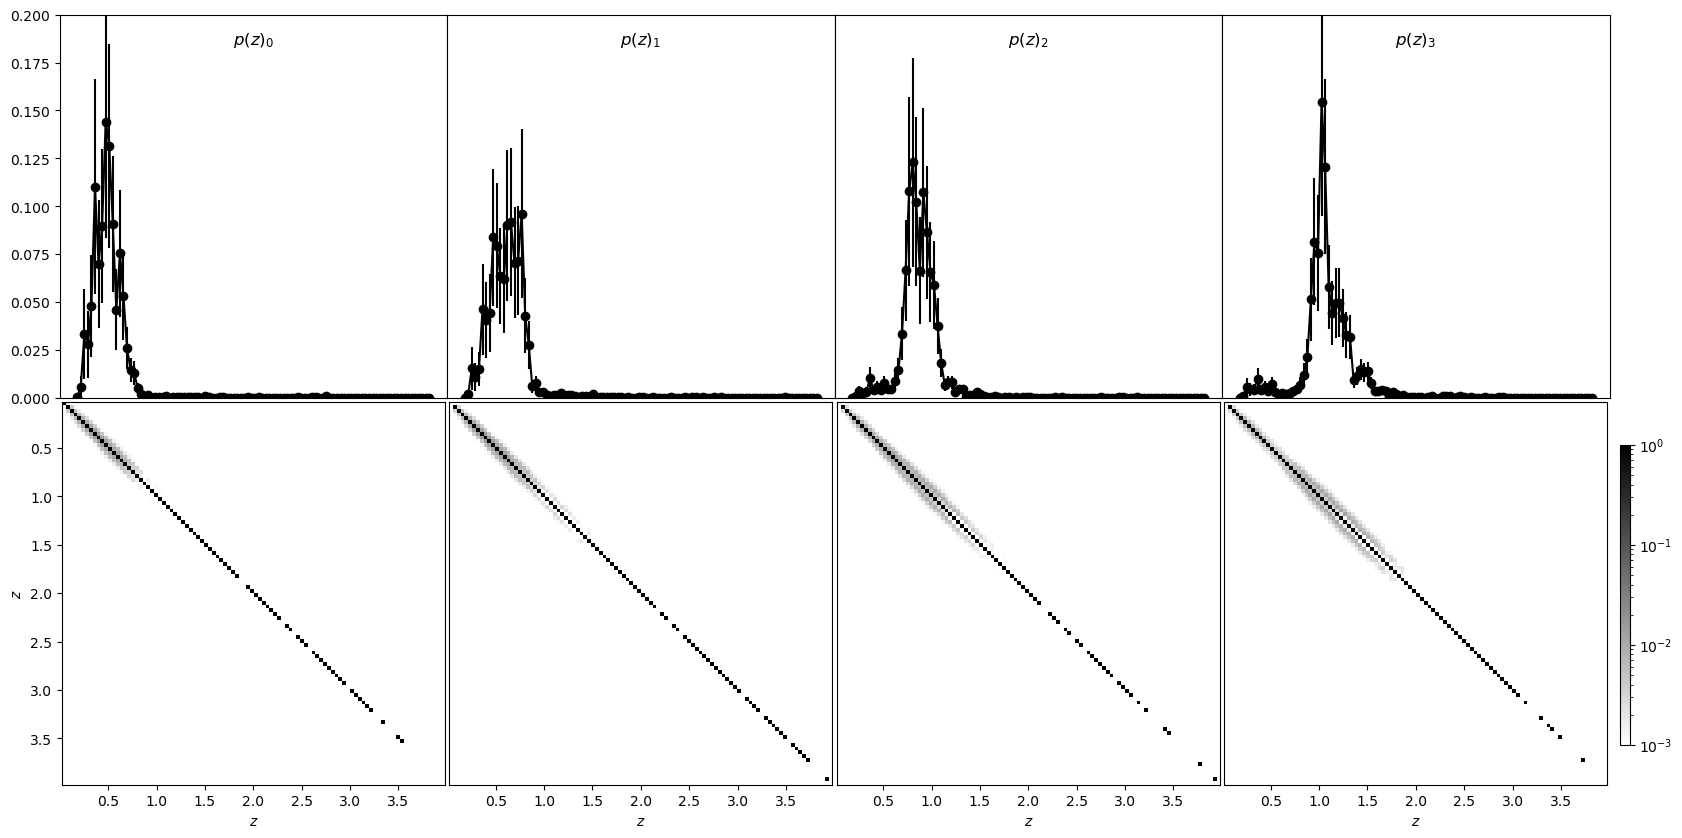

In [11]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
for (name, nz) in CGG_nzs.items():
    if 'DES' in name:
        z = nz[0]
        dndz = nz[1]
        cov = nz[2]
        err = np.sqrt(np.diag(cov))
        corr = cov / (np.outer(err, err))
        axis[0 , i].errorbar(z, dndz, yerr=err,
                            fmt='{}o-'.format(colorss[i]), label="$DESY1wl_{}$".format(i))
        axis[0, i].set_ylim(0, 0.2)
        axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
        axis[0, i].set_xticks([])
        im = axis[1, i].imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                           extent=[min(z), max(z), max(z), min(z)])
        axis[1, i].set_xlabel(r"$z$")
        if i > 0:
            axis[0, i].set_yticks([])
            axis[1, i].set_yticks([])
        else:
            axis[1, i].set_ylabel(r"$z$")
        i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()


100
100
100
100


/tmp/ipykernel_8094/697630612.py:13: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


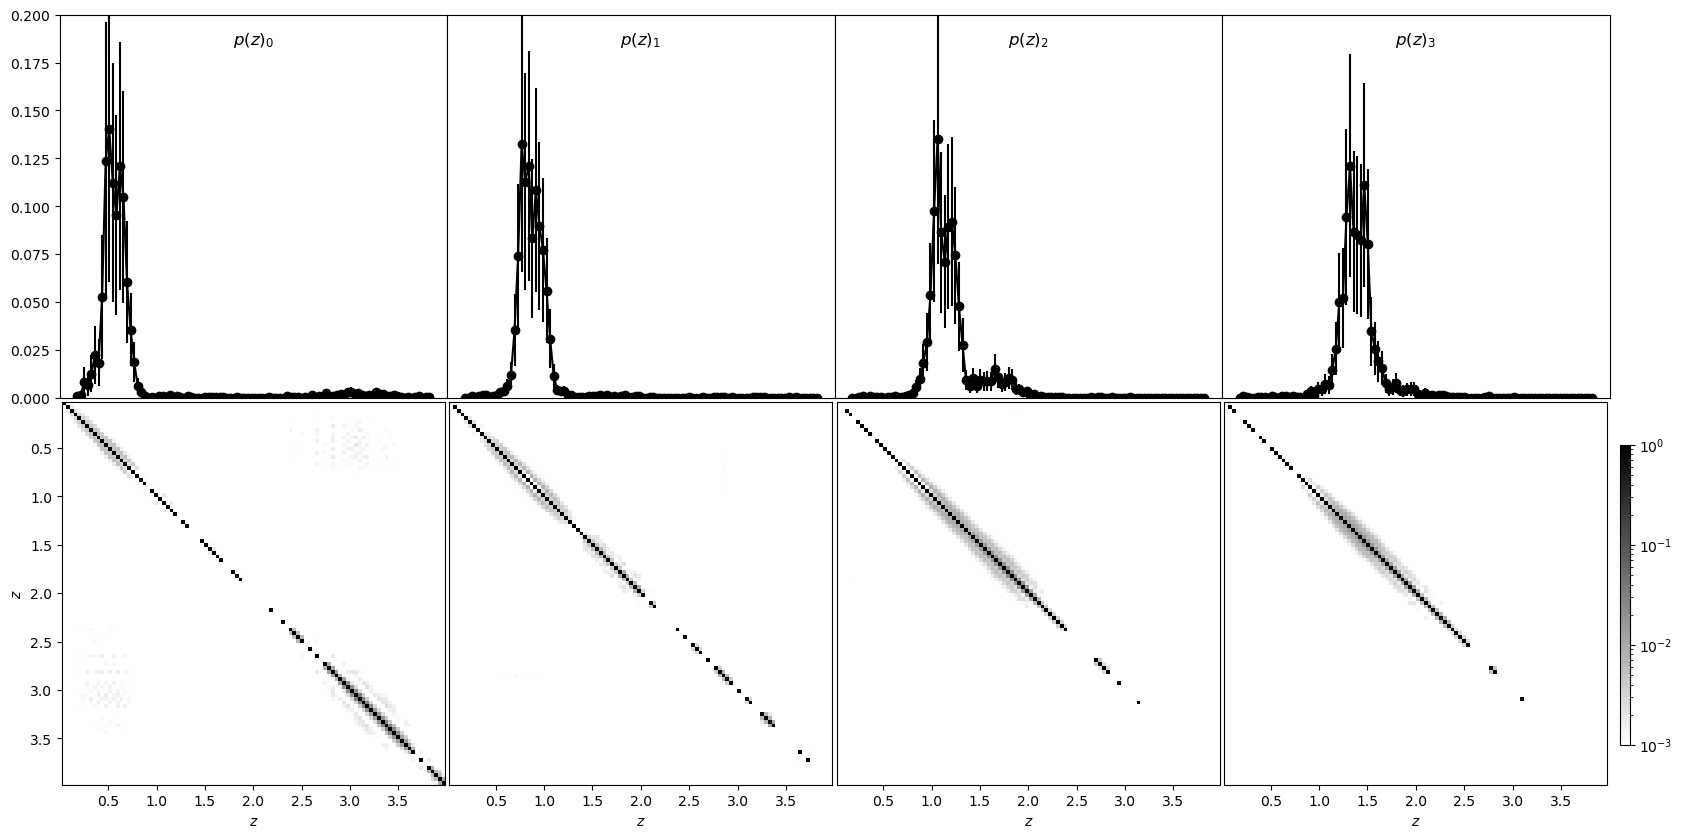

In [12]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
for (name, nz) in CGG_nzs.items():
    if 'HSC' in name:
        print(len(nz[0]))
        z = nz[0]
        dndz = nz[1]
        cov = nz[2]
        err = np.sqrt(np.diag(cov))
        corr = cov / (np.outer(err, err))
        axis[0 , i].errorbar(z, dndz, yerr=err,
                            fmt='{}o-'.format(colorss[i]), label="$DESY1wl_{}$".format(i))
        axis[0, i].set_ylim(0, 0.2)
        axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
        axis[0, i].set_xticks([])
        im = axis[1, i].imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                           extent=[min(z), max(z), max(z), min(z)])
        axis[1, i].set_xlabel(r"$z$")
        if i > 0:
            axis[0, i].set_yticks([])
            axis[1, i].set_yticks([])
        else:
            axis[1, i].set_ylabel(r"$z$")
        i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()

In [19]:
zbound = np.linspace(0.0,6.001,300)
zbin = (zbound[1:]+zbound[:-1])/2
nzs_TQ['HSC__0_nz'].shape

(10000, 299)

In [104]:
from scipy.interpolate import interp1d
import scipy.stats as stats

shifted_nzs = {}
for key in list(nzs_TQ.keys()):
    print(key)
    nzs = nzs_TQ[key]
    stds = np.std(nzs, axis=1)
    s_stds = np.std(stds)
    m_stds = np.mean(stds)
    y = s_stds/m_stds
    mu = np.mean(nzs, axis=0)
    shift_prior = stats.norm(loc=0, scale=y)
    zs =  [zbin + shift_prior.rvs() for i in range(1000)]
    shifted_nzs[key] = [interp1d(z, mu, kind='linear', fill_value='extrapolate')(zbin) for z in zs]

HSC__0_nz
HSC__1_nz
HSC__2_nz
HSC__3_nz


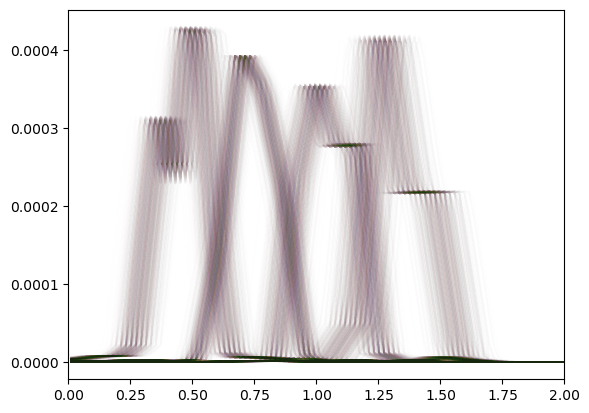

In [117]:
for key in list(shifted_nzs.keys()):
    nzs = shifted_nzs[key]
    for i in range(1000):
        plt.plot(zbin, nzs[i], alpha=0.005)
    plt.xlim(0, 2)

/tmp/ipykernel_8094/3884002526.py:13: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


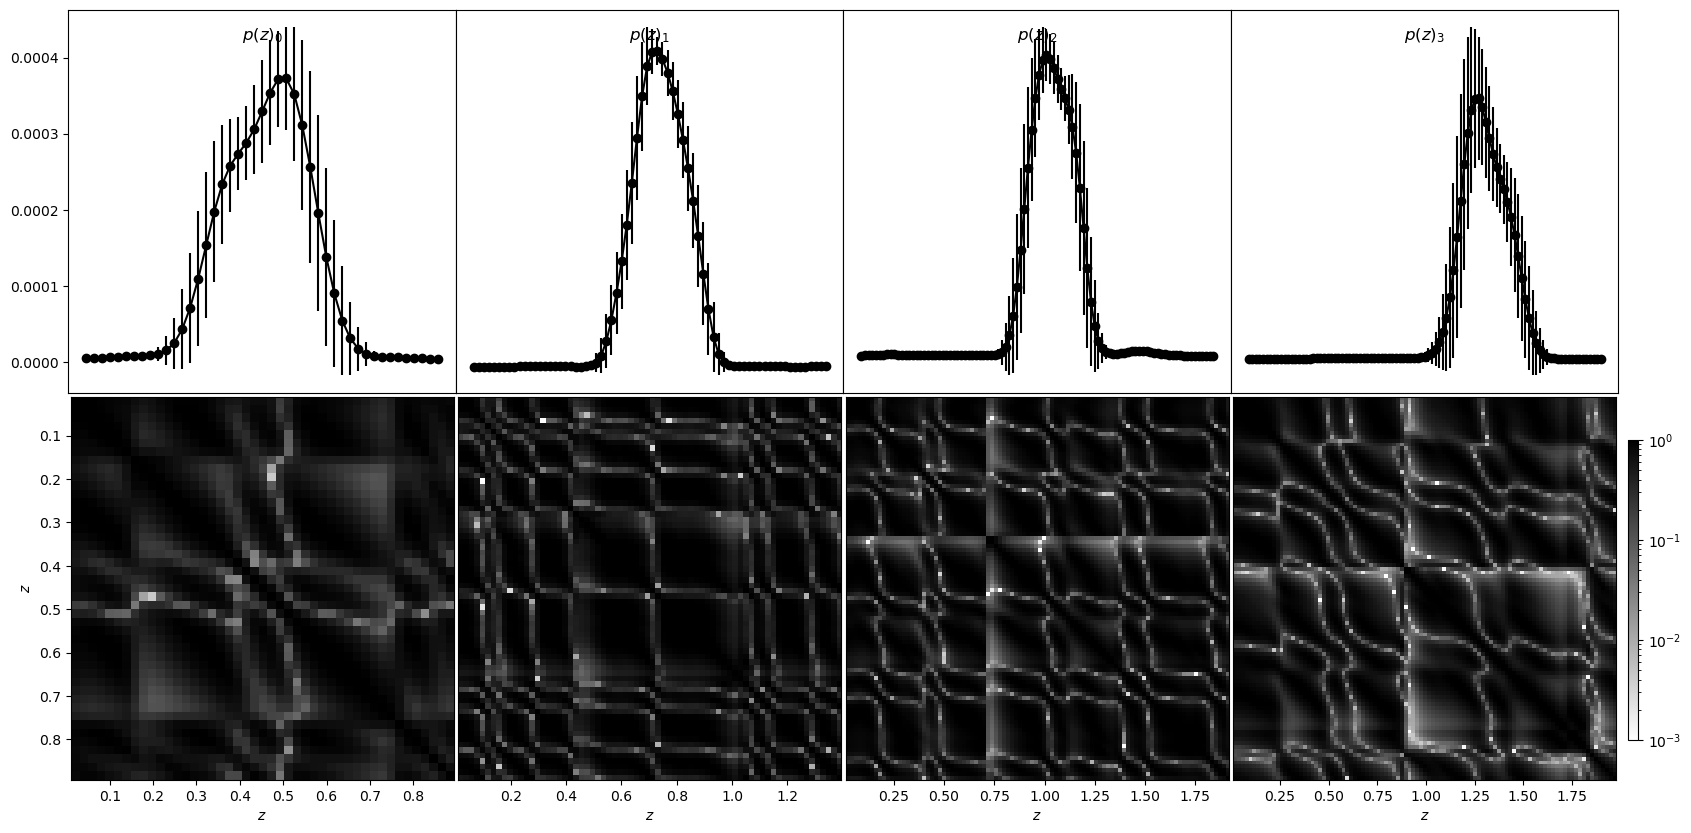

In [115]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
for name in list(shifted_nzs.keys()):
    nzs = np.array(shifted_nzs[name])
    m = np.mean(nzs, axis=0)
    s = np.std(nzs, axis=0)
    cov = np.cov(nzs.T)
    sel = sels[i]
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    axis[0 , i].errorbar(zbin[:sel], m[:sel], yerr=err[:sel],
                        fmt='{}o-'.format(colorss[i]),
                        label="$DESY1wl_{}$".format(i))
    #axis[0, i].set_ylim(0, 0.2)
    axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
    axis[0, i].set_xticks([])
    im = axis[1, i].imshow(abs(corr[:sel, :sel]), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                        extent=[min(zbin[:sel]), max(zbin[:sel]), max(zbin[:sel]), min(zbin[:sel])])
    axis[1, i].set_xlabel(r"$z$")
    if i > 0:
        axis[0, i].set_yticks([])
        axis[1, i].set_yticks([])
    else:
        axis[1, i].set_ylabel(r"$z$")
    i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()

In [114]:
sels = [45, 70, 96, 99]

45
70
96


/tmp/ipykernel_8094/3175569214.py:16: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


99


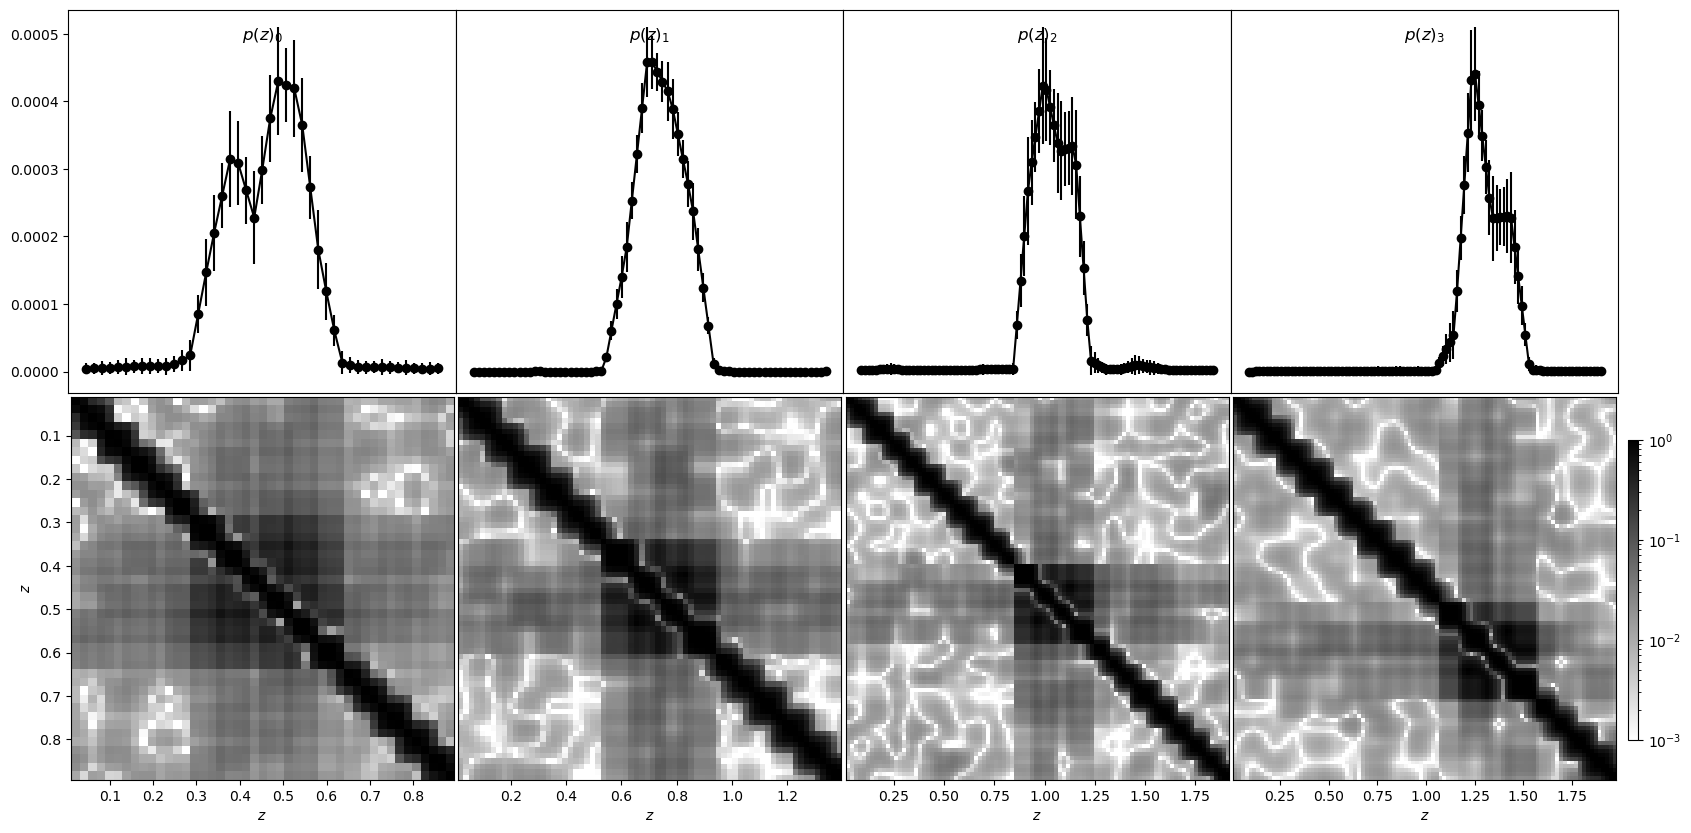

In [112]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
for name in list(nzs_TQ.keys()):
    nzs = nzs_TQ[name]
    m = np.mean(nzs, axis=0)
    s = np.std(nzs, axis=0)
    cov = np.cov(nzs.T)
    sel = cov[0, :] > 0
    sel, = np.where(zbin == zbin[sel][-1])
    sel = sel[0]
    print(sel)
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    axis[0 , i].errorbar(zbin[:sel], m[:sel], yerr=err[:sel],
                        fmt='{}o-'.format(colorss[i]),
                        label="$DESY1wl_{}$".format(i))
    #axis[0, i].set_ylim(0, 0.2)
    axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
    axis[0, i].set_xticks([])
    im = axis[1, i].imshow(abs(corr[:sel, :sel]), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                        extent=[min(zbin[:sel]), max(zbin[:sel]), max(zbin[:sel]), min(zbin[:sel])])
    axis[1, i].set_xlabel(r"$z$")
    if i > 0:
        axis[0, i].set_yticks([])
        axis[1, i].set_yticks([])
    else:
        axis[1, i].set_ylabel(r"$z$")
    i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()

In [16]:
np.mean(nzs_TQ['HSC__0_nz'], axis=0)[:50]

array([4.38600203e-06, 4.65550622e-06, 4.92501041e-06, 5.70812087e-06,
       6.61425720e-06, 7.45571253e-06, 7.79202430e-06, 8.12833606e-06,
       8.27879204e-06, 8.17286963e-06, 8.06694723e-06, 1.17520340e-05,
       1.68605561e-05, 2.38716331e-05, 8.53089230e-05, 1.46746213e-04,
       2.05870500e-04, 2.60515451e-04, 3.15160402e-04, 3.08412223e-04,
       2.68210219e-04, 2.28008216e-04, 2.98783610e-04, 3.74905062e-04,
       4.29804689e-04, 4.24553061e-04, 4.19301433e-04, 3.64775897e-04,
       2.72705925e-04, 1.80635953e-04, 1.18705953e-04, 6.11089657e-05,
       1.33931905e-05, 1.03697909e-05, 7.34639136e-06, 6.00038527e-06,
       6.41555443e-06, 6.83072359e-06, 6.50769520e-06, 5.99381443e-06,
       5.48311710e-06, 5.00065358e-06, 4.51819006e-06, 4.40312657e-06,
       4.82097041e-06, 5.23881426e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

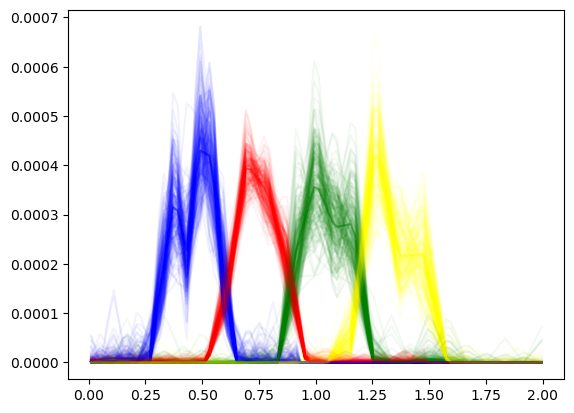

In [17]:
plt.plot(zbin[:100], np.mean(nzs_TQ['HSC__0_nz'], axis=0)[:100], color = 'blue',alpha = 0.5 )
plt.plot(zbin[:100], np.mean(nzs_TQ['HSC__1_nz'], axis=0)[:100], color = 'red',alpha = 0.5 )
plt.plot(zbin[:100], np.mean(nzs_TQ['HSC__2_nz'], axis=0)[:100], color = 'green',alpha = 0.5)
plt.plot(zbin[:100], np.mean(nzs_TQ['HSC__3_nz'], axis=0)[:100], color = 'yellow',alpha = 0.5)

#show 
for i in range(200):
    plt.plot(zbin[:100], nzs_TQ['HSC__0_nz'][i,:100], color = 'blue', alpha = 0.05)
    plt.plot(zbin[:100], nzs_TQ['HSC__1_nz'][i,:100], color = 'red', alpha = 0.05)
    plt.plot(zbin[:100], nzs_TQ['HSC__2_nz'][i,:100], color = 'green', alpha = 0.05)
    plt.plot(zbin[:100], nzs_TQ['HSC__3_nz'][i,:100], color = 'yellow', alpha = 0.05)


In [141]:
new_nzs_file = {}
new_nzs_file['HSC__0'] = nzs_TQ['HSC__0_nz']
new_nzs_file['HSC__1'] = nzs_TQ['HSC__1_nz']
new_nzs_file['HSC__2'] = nzs_TQ['HSC__2_nz']
new_nzs_file['HSC__3'] = nzs_TQ['HSC__3_nz']
new_nzs_file['zs'] = zbin

In [142]:
np.savez('../RAIL_projector/HSC_nzs_TQ.npz', **new_nzs_file)

In [140]:
new_nzs_file['HSC__0']

{'zs': array([0.01003512, 0.03010535, 0.05017559, 0.07024582, 0.09031605,
        0.11038629, 0.13045652, 0.15052676, 0.17059699, 0.19066722,
        0.21073746, 0.23080769, 0.25087793, 0.27094816, 0.29101839,
        0.31108863, 0.33115886, 0.3512291 , 0.37129933, 0.39136957,
        0.4114398 , 0.43151003, 0.45158027, 0.4716505 , 0.49172074,
        0.51179097, 0.5318612 , 0.55193144, 0.57200167, 0.59207191,
        0.61214214, 0.63221237, 0.65228261, 0.67235284, 0.69242308,
        0.71249331, 0.73256355, 0.75263378, 0.77270401, 0.79277425,
        0.81284448, 0.83291472, 0.85298495, 0.87305518, 0.89312542,
        0.91319565, 0.93326589, 0.95333612, 0.97340635, 0.99347659,
        1.01354682, 1.03361706, 1.05368729, 1.07375753, 1.09382776,
        1.11389799, 1.13396823, 1.15403846, 1.1741087 , 1.19417893,
        1.21424916, 1.2343194 , 1.25438963, 1.27445987, 1.2945301 ,
        1.31460033, 1.33467057, 1.3547408 , 1.37481104, 1.39488127,
        1.41495151, 1.43502174, 1.45509197